# 2. Customizing Keras Models and Training

In the first tutorial we leared how to define keras models and make simple changes to their architecture (number of layers, layer sizes, activations, etc). We've only scratched the surface of what is possible. 

In this tutorial we will learn how to:

- further customize our models' architecture details
- choosing a loss function
- customize the optimizer and its parameters (learning rate, momentum, etc.)
- customize the model's training (train on minibatches, early stopping etc.)
- save and load keras models

Let's first import the necessary libraries

In [1]:
import tensorflow as tf
assert tf.__version__[0] == '2', 'this tutorial is for tensorflow versions of 2 or higher'

import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

2023-03-11 21:39:07.688522: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-11 21:39:09.031875: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-11 21:39:09.032046: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-11 21:39:11.785366: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

We'll work on the same dataset as we did in the previous tutorial

In [3]:
np.random.seed(13)

X, y = make_moons(300, noise=0.1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

######################################################################
############################## PLOTTING ##############################
######################################################################

def visualize_decision_boundary(model):
    """
    Helper function that visualizes a model's decision boundary on the
    previously defined moons dataset
    """
    # Find out where to start and end the mesh
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

    # Generate the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05, dtype=np.float32),
                         np.arange(y_min, y_max, 0.05, dtype=np.float32))

    # Generate predictions for each point of the mesh
    mesh_preds = model(np.c_[xx.ravel(), yy.ravel()]).numpy()

    # We'll also create a custom diverging colormap from blue to orange. 
    # Details here:
    # https://matplotlib.org/3.1.0/tutorials/colors/colormap-manipulation.html 

    blue = matplotlib.colormaps['Blues']
    orange = matplotlib.colormaps['Oranges_r']

    color_array = np.vstack((blue(np.linspace(0, 1, 128)),
                             orange(np.linspace(0, 1, 128))))

    BuOr = matplotlib.colors.ListedColormap(color_array)

    # Create the figure
    plt.figure(figsize=(8, 6))
    ax = plt.subplot(111)

    # Draw the mesh predictions as contours
    ax.contourf(xx, yy, mesh_preds.reshape(xx.shape), cmap=BuOr, alpha=0.4)

    # Draw the data points in their actual colors
    colors = ['C' + str(int(i)) for i in y_test]
    ax.scatter(X_test[:, 0], X_test[:, 1], c=colors)

    ax.axis('off')
    ax.set_title('Test set samples and predictions')

## Loss Function

We'll start by arguably the most important component. The choice of the loss function is actually not up to us most of the times; rather it's defined by the task we have to solve. Usually we choose the most popular loss for the desired task.

Up till now, we've been using a [**cross-entropy**](https://en.wikipedia.org/wiki/Cross_entropy), which should be the default choice for any **classification** task:

$$
J(y, \hat y) = - \sum_{i=1}^N y_i \cdot \log \hat y_i
$$

where $N$ is the number of samples in the sets $y$ and $\hat y$.

In Keras, this loss function comes in two main flavors:

- `binary_crossentropy`, which should be used for binary classification
- `categorical_crossentropy`, which should be used for multiclass classification

If you want to learn more about what this function actually does, you can read [this blog post](http://rdipietro.github.io/friendly-intro-to-cross-entropy-loss/).

If we have a **regression** task, we should start with using a **Mean Squared Error** loss:

$$
J(y, \hat y) = \frac{1}{N}\sum_{i=1}^N{(y - \hat y)^2}
$$

## Optimizers

One thing that was very noticable fron the 1st tutorial was the very slow convergence speeds. One thing we could try would be to increase the **learning rate** or even add a bit of **momentum** to the optimizer. To do this we have to instantiate our own [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) object.

In [9]:
# Define the same model as we had in the previous tutorial
inp = tf.keras.layers.Input(shape=(2,)) 
hid = tf.keras.layers.Dense(30, activation='relu')(inp)
out = tf.keras.layers.Dense(1, activation='sigmoid')(hid)
mlp = tf.keras.models.Model(inp, out)

# Create a SGD object with the desired parameters
sgd = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.1)

# Compile and train the model
mlp.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
mlp.fit(X_train, y_train, epochs=100)  # we'll train for fewer epochs since training is faster now

Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7597 - accuracy: 0.3980
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6315 - accuracy: 0.7164
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 0.5554 - accuracy: 0.8408
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4980 - accuracy: 0.8358
Epoch 5/100
7/7 [==============================] - 0s 3ms/step - loss: 0.4543 - accuracy: 0.8308
Epoch 6/100
7/7 [==============================] - 0s 3ms/step - loss: 0.4231 - accuracy: 0.8308
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3977 - accuracy: 0.8308
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3786 - accuracy: 0.8308
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3628 - accuracy: 0.8308
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3514 - accuracy: 0.8308
Epoch 11/100
7/7 [===========

You can see in the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) that a great deal of stuff are available from the optimizer, such as weight decay, nesterov acceleration, gradient cliping, and more. 

We started using SGD since it the most "vanilla" optimization strategy we could choose. However, in practice, we would probably want to start out with a more advanced algorithm, like [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam). If you want to learn more about optimizers, an excellent overview of the different optimizers can be found [here](https://ruder.io/optimizing-gradient-descent/).

In [19]:
# Re-define the model so that we have a "fair" comparison
inp = tf.keras.layers.Input(shape=(2,)) 
hid = tf.keras.layers.Dense(30, activation='relu')(inp)
out = tf.keras.layers.Dense(1, activation='sigmoid')(hid)
mlp = tf.keras.models.Model(inp, out)

adam = tf.keras.optimizers.Adam(learning_rate=0.01)  # instantiate Adam with high LR

mlp.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
mlp.fit(X_train, y_train, epochs=100) 

Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 0.5981 - accuracy: 0.7512
Epoch 2/100
7/7 [==============================] - 0s 3ms/step - loss: 0.4689 - accuracy: 0.8060
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3894 - accuracy: 0.8209
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3446 - accuracy: 0.8308
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3176 - accuracy: 0.8358
Epoch 6/100
7/7 [==============================] - 0s 3ms/step - loss: 0.2980 - accuracy: 0.8408
Epoch 7/100
7/7 [==============================] - 0s 3ms/step - loss: 0.2856 - accuracy: 0.8458
Epoch 8/100
7/7 [==============================] - 0s 3ms/step - loss: 0.2693 - accuracy: 0.8657
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2631 - accuracy: 0.8756
Epoch 10/100
7/7 [==============================] - 0s 3ms/step - loss: 0.2548 - accuracy: 0.8706
Epoch 11/100
7/7 [===========

We got a much quicker convergence with this configuration. If you're interested in seeing how the different optimizers and LR configurations compare to each other in this problem you can see the figure below:

![](https://github.com/djib2011/tensorflow-training/blob/main/figures/optimizer_comparison.png)

A couple of things to be aware of:
1. The best optimizer configuration depends on the problem we want to solve. Because we happened to get a better performance off of Adam with $lr=0.1$, this doesn't mean that this will be the case for every task.
2. Different optimizers have different values for their parameters. For instance SGD has a default learning rate of $0.01$, while Adam, which is by much faster, has a default learning rate of $0.001$. Keep this in mind when you are hyper-parameter tuning these components. Not all values are suitable for all optimizers.

Let's visualize our trained model's decision boundary.

4/4 [==============================] - 0s 2ms/step - loss: 0.0247 - accuracy: 0.9899


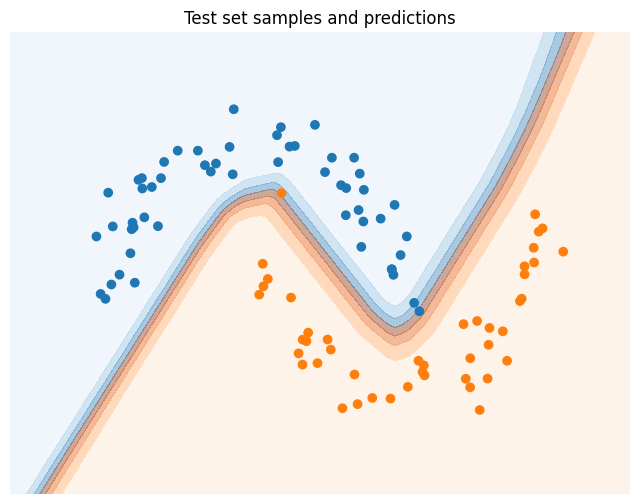

In [25]:
mlp.evaluate(X_test, y_test)

visualize_decision_boundary(mlp)

Unfortunately, we can't do much better than the above ;) We'll continue investigating the different things we can customize in the model's architecture and training, even if we aren't driven by performance anymore.

## Layer parameters

The layers in keras are highly customizable. Besides their size and activation, which we've already seen. There are a lot of other tools we can use, such as removing the bias, changing the initializer, adding regularization (e.g. L2) or adding constraints (e.g. max norm) to a specific layer. If you recall, some of these could be controlled on a global level from the optimizer, through layer configurations we can manage to customize each layer individually. For an example, you can look at the [documentation of keras' Dense layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense).

### Initializers

An initializer essentialy is a distribution from which we keras will draw the initial values for the model's parameters. Strangely enough, using a good initializer is more important than it seems! A list of all available initializers can be found [here](https://www.tensorflow.org/api_docs/python/tf/keras/initializers).

When initializing a layer's parameters, we **don't** want our weights to start with a value of $0$, however we usually start our biases as zeros. That being said the default initializer is pretty good so we don't usually change it!

Initializers are applied **for each layer individually** and separately for weights and biases.

In [31]:
inp = tf.keras.layers.Input(shape=(2,)) 
hid = tf.keras.layers.Dense(30, activation='relu',
                            kernel_initializer='he_normal',  # weight initializer
                            bias_initializer='zeros'         # bias initializer
                                                             # 'zeros' is actually the default value so this 
                                                             # line is redundant
                             )(inp)
out = tf.keras.layers.Dense(1, activation='sigmoid')(hid)

mlp = tf.keras.models.Model(inp, out)

adam = tf.keras.optimizers.Adam(learning_rate=0.01)  # re-initialize the optimizer so that it forgets its state
mlp.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])  

mlp.fit(X_train, y_train, epochs=100) 

Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7386 - accuracy: 0.5522
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4046 - accuracy: 0.8408
Epoch 3/100
7/7 [==============================] - 0s 3ms/step - loss: 0.3433 - accuracy: 0.8358
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3167 - accuracy: 0.8408
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3008 - accuracy: 0.8408
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2921 - accuracy: 0.8358
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2840 - accuracy: 0.8308
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2751 - accuracy: 0.8408
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2695 - accuracy: 0.8458
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2657 - accuracy: 0.8557
Epoch 11/100
7/7 [===========

### Removing biases

Modern Neural Network architectures sometimes remove the biases altogether!

In this example the biases are pretty important! It isn't a good decision to remove them, but it will be interesting to examine the impact they have to the model.

In [33]:
inp = tf.keras.layers.Input(shape=(2,)) 
hid = tf.keras.layers.Dense(30, activation='relu',
                            kernel_initializer='he_normal',  # weight initializer
                            use_bias=False,  # don't have biases at all
                            )(inp)
out = tf.keras.layers.Dense(1, activation='sigmoid')(hid)

mlp = tf.keras.models.Model(inp, out)

adam = tf.keras.optimizers.Adam(learning_rate=0.01)
mlp.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])  

mlp.fit(X_train, y_train, epochs=100) 

Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7246 - accuracy: 0.6070
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 0.5314 - accuracy: 0.7015
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 0.4523 - accuracy: 0.7264
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3857 - accuracy: 0.7910
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 0.3443 - accuracy: 0.8408
Epoch 6/100
7/7 [==============================] - 0s 3ms/step - loss: 0.3249 - accuracy: 0.8458
Epoch 7/100
7/7 [==============================] - 0s 3ms/step - loss: 0.3112 - accuracy: 0.8308
Epoch 8/100
7/7 [==============================] - 0s 3ms/step - loss: 0.3058 - accuracy: 0.8408
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2982 - accuracy: 0.8458
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.2901 - accuracy: 0.8607
Epoch 11/100
7/7 [===========

4/4 [==============================] - 0s 2ms/step - loss: 0.2117 - accuracy: 0.8990


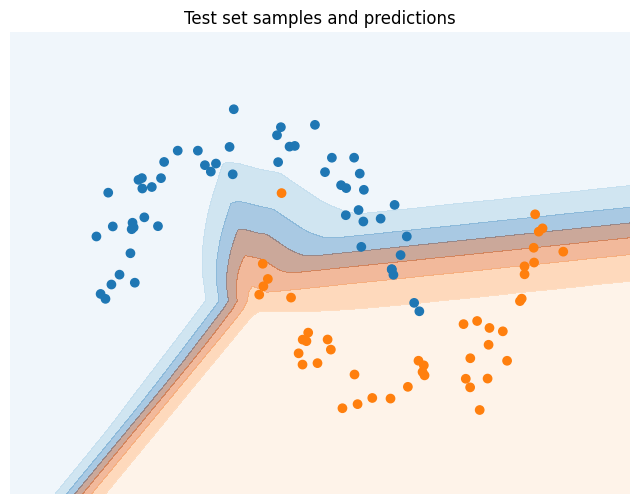

In [34]:
mlp.evaluate(X_test, y_test)

visualize_decision_boundary(mlp)

### Regularization through norm penalties

A common regularization technique in Machine Learning (though not so popular in Deep Learning) are **parameter norm penalties**. The intuition behind this is that we want to keep the values of our parameters small, so that our model doesn't overfit. So we add a term to the loss function proportional to the norm of the parameters. The optimizer, wanting to minimize the loss, will on one hand try to reduce the classification loss, but on the other hand it will try to reduce the parameter norms, thus leadnig to smaller parameters.

Depending on which norm we want to use (the first or the second), there are two typers of regularizers:

- [L1 regularizer](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l1) (penalty proportional to the first norm).
- [L2 regularizer](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l2) (penalty proportional to the second norm).
- [L1-L2 regularizer](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l1_l2) (penalty based on both norms).

We can apply the regularization to the weights (`kernel_regularizer`), the biases (`bias_regularizer`) or the activations (`activity_regularizer`). Regularizers this way are applied to each layer individually, but can be also applied globally through the optimizer's `weight_decay` option.

In [39]:
inp = tf.keras.layers.Input(shape=(2,)) 
hid = tf.keras.layers.Dense(30, activation='relu',
                            kernel_initializer='he_normal',
                            kernel_regularizer='l2',  # L2 penalty to the weights
                            bias_regularizer='l1',    # L1 penalty to the biases
                            )(inp)
out = tf.keras.layers.Dense(1, activation='sigmoid')(hid)

mlp = tf.keras.models.Model(inp, out)

adam = tf.keras.optimizers.Adam(learning_rate=0.01)
mlp.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])  

mlp.fit(X_train, y_train, epochs=100) 

Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2154 - accuracy: 0.3134
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9772 - accuracy: 0.7413
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 0.8402 - accuracy: 0.7811
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7483 - accuracy: 0.8109
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6878 - accuracy: 0.8259
Epoch 6/100
7/7 [==============================] - 0s 3ms/step - loss: 0.6371 - accuracy: 0.8308
Epoch 7/100
7/7 [==============================] - 0s 3ms/step - loss: 0.5942 - accuracy: 0.8408
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 0.5593 - accuracy: 0.8408
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.5275 - accuracy: 0.8408
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.5014 - accuracy: 0.8507
Epoch 11/100
7/7 [===========

## Training

Up till now, we've kept what is happenning inside `model.fit()` a bit vague. This method essentially runs a **training loop**. A simplified version of what happens inside this training loop is illustrated in the pseudocode below

```python
for epoch in range(num_epochs):  # iterate over the number of epochs

    shuffle(training_set)  # optionally shuffle the training set at the beginning of each epoch
    
    for batch in training_set:   # pass through the training set batch by batch
        x, y = batch             # each batch consists of the features and the labels
        y_hat = model.predict(x)
        optimizer.update(model)  # update the model's parameters depending on the gradient
                                 # of the loss between y and y_hat
   
    # After the training phase, at the end of each epoch, run a validation phase 
    for x, y in validation_set:
        y_hat = model.predict(x)
        [metric(y, y_hat) for metric in metrics]  # measure each metric on the validation set
```

Now that we have a better understanding of what happens inside fit, we can see how we can configure these things.

In [41]:
inp = tf.keras.layers.Input(shape=(2,)) 
hid = tf.keras.layers.Dense(30, activation='relu')(inp)
out = tf.keras.layers.Dense(1, activation='sigmoid')(hid)

mlp = tf.keras.models.Model(inp, out)

adam = tf.keras.optimizers.Adam(learning_rate=0.01)
mlp.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])  


mlp.fit(X_train, y_train,
        epochs=100,  # number of epochs
        batch_size=32,  # batch size this line is redundant
                        # because the default batch size is 32
        validation_data=(X_test, y_test)) # the model will be evaluated on the
                                          # test set at the end of each epoch

Epoch 1/100
7/7 [==============================] - 1s 22ms/step - loss: 0.5972 - accuracy: 0.7662 - val_loss: 0.4915 - val_accuracy: 0.7980
Epoch 2/100
7/7 [==============================] - 0s 6ms/step - loss: 0.4711 - accuracy: 0.8159 - val_loss: 0.3829 - val_accuracy: 0.8283
Epoch 3/100
7/7 [==============================] - 0s 6ms/step - loss: 0.3882 - accuracy: 0.8209 - val_loss: 0.3248 - val_accuracy: 0.8384
Epoch 4/100
7/7 [==============================] - 0s 7ms/step - loss: 0.3461 - accuracy: 0.8259 - val_loss: 0.2851 - val_accuracy: 0.8788
Epoch 5/100
7/7 [==============================] - 0s 7ms/step - loss: 0.3172 - accuracy: 0.8308 - val_loss: 0.2650 - val_accuracy: 0.8889
Epoch 6/100
7/7 [==============================] - 0s 6ms/step - loss: 0.2995 - accuracy: 0.8458 - val_loss: 0.2518 - val_accuracy: 0.8990
Epoch 7/100
7/7 [==============================] - 0s 6ms/step - loss: 0.2839 - accuracy: 0.8507 - val_loss: 0.2422 - val_accuracy: 0.9192
Epoch 8/100
7/7 [=========

### Callbacks

`model.fit()` is very convenient because it very easily allows us to train a model. However, by hiding the training loop, it removes a lot of the flexibility we would have to do more complex stuff (e.g. do some operation at the end of each batch or epoch).

To help us with this, Keras provides a mechanism called **callbacks**. Callbacks are essentially **functions that are called within the training loop**. Keras allows us to write our own such functions, however now we'll focus on three build-in ones, to understand their logic.

#### Early Stopping

Early stopping is a mechanism that allows us to prematurely end the training loop if a condition is met. This can be set up in keras by using the [`EarlyStopping`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) callback.

In [42]:
inp = tf.keras.layers.Input(shape=(2,)) 
hid = tf.keras.layers.Dense(30, activation='relu')(inp)
out = tf.keras.layers.Dense(1, activation='sigmoid')(hid)

mlp = tf.keras.models.Model(inp, out)

adam = tf.keras.optimizers.Adam(learning_rate=0.01)
mlp.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])  

# Define an EarlyStopping strategy
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  min_delta=0.01,   
                                                  patience=3,      
                                                  start_from_epoch=50)

mlp.fit(X_train, y_train, epochs=100,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping])  # pass callbacks as a list 

Epoch 1/100
7/7 [==============================] - 1s 31ms/step - loss: 0.7006 - accuracy: 0.4677 - val_loss: 0.5700 - val_accuracy: 0.7576
Epoch 2/100
7/7 [==============================] - 0s 7ms/step - loss: 0.5375 - accuracy: 0.7612 - val_loss: 0.4467 - val_accuracy: 0.8081
Epoch 3/100
7/7 [==============================] - 0s 6ms/step - loss: 0.4445 - accuracy: 0.8060 - val_loss: 0.3684 - val_accuracy: 0.8283
Epoch 4/100
7/7 [==============================] - 0s 7ms/step - loss: 0.3851 - accuracy: 0.8159 - val_loss: 0.3197 - val_accuracy: 0.8384
Epoch 5/100
7/7 [==============================] - 0s 7ms/step - loss: 0.3466 - accuracy: 0.8259 - val_loss: 0.2859 - val_accuracy: 0.8687
Epoch 6/100
7/7 [==============================] - 0s 6ms/step - loss: 0.3250 - accuracy: 0.8308 - val_loss: 0.2596 - val_accuracy: 0.8889
Epoch 7/100
7/7 [==============================] - 0s 7ms/step - loss: 0.3022 - accuracy: 0.8408 - val_loss: 0.2539 - val_accuracy: 0.8990
Epoch 8/100
7/7 [=========

We can see from above that the callback was actually triggered and the network stopped its training before $100$ epochs. What kind of early stopping strategy did we use though and what do the different parameters of the callback mean?

- `monitor='val_loss'`: this means that the callback will monitor the validation loss and make its decision on whether to stop or not based on this metric.
- `min_delta=0.01`: this tells the callback to trigger if it sees an improvement$^1$ of less than $0.01$ from iteration to iteration on the metric it is monitoring.
- `patience=3`: this means that the `min_delta` condition should be true in $3$ consecutive iterations in order for the callback to trigger a stop in the training. 
- `start_from_epoch=50`: is more or less self-explanatory; this whole process of monitoring changes starts at epoch $50$.

$^1$ This is subjective. In some metrics "improvement" means lower is better (e.g. `loss`, `val_loss`), while in others higher is better (e.g. `accuracy`). 

One question we haven't raised at all is why early stop our model? This is because the reasons for doing this and how to implement the proper strategy are design choices influenced by the task at hand and are purposefully left out of the scope of this tutorial.

#### ModelCheckpoint

Model checkpoints are a way to save the model, during training, if a condition is triggered. We will talk more about saving/loading models in a bit, but it's interesting to discuss the [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback here, due to its relateness to `EarlyStopping`.

In [43]:
inp = tf.keras.layers.Input(shape=(2,)) 
hid = tf.keras.layers.Dense(30, activation='relu')(inp)
out = tf.keras.layers.Dense(1, activation='sigmoid')(hid)

mlp = tf.keras.models.Model(inp, out)

adam = tf.keras.optimizers.Adam(learning_rate=0.01)
mlp.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])  

# Define a ModelCheckpoint strategy
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                                        filepath='/tmp/tf101_models',
                                        save_weights_only=True,
                                        monitor='val_accuracy',
                                        mode='max',
                                        save_best_only=True)


mlp.fit(X_train, y_train, epochs=100,
        validation_data=(X_test, y_test),
        callbacks=[model_checkpoint])  # pass callbacks as a list 

'3.9.13 (main, May 18 2022, 00:00:00) \n[GCC 11.3.1 20220421 (Red Hat 11.3.1-2)]'

In [ ]:
mlp.evaluate(X_test, y_test)

visualize_decision_boundary(mlp)

The above figure has a much better appearance than the previous plots, which is the reason for the higher accuracy.

## Exporting and Importing a keras model

A model has two components: its architecture and its parameters. The first is what we defined when building the model, while the second is the values that the model's parameters took during training. All of the *knowledge* the model accumulated during training, is stored in these parameters!

Let's see an example:

In [0]:
# 1. Build a new model with the same architecture as the previous
inp = tf.keras.layers.Input(shape=(2,)) 
hid1 = tf.keras.layers.Dense(10, activation='relu',)(inp)
hid2 = tf.keras.layers.Dense(3, activation='relu')(hid1)
out = tf.keras.layers.Dense(1, activation='sigmoid')(hid2)
model2 = tf.keras.models.Model(inp, out)
model2.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

# 2. Evaluate its performance
print('Test set accuracy: {:.2f}%'.format(model2.evaluate(X_test, y_test, verbose=0)[1]))

# 3. Transfer the weights from the trained model
weights = mlp.get_weights()  # retrieve the weights as a list of arrays
model2.set_weights(weights)   # transfer the weights to the new model

# 4. Re-evaluate its performance
print('Test set accuracy: {:.2f}%'.format(model2.evaluate(X_test, y_test, verbose=0)[1]))

Test set accuracy: 0.55%
Test set accuracy: 0.93%


The model was randomly predicting when it was first initializer, but predicts accurately once trained.

This means that by storing the model's weights, we are storing all the necessary information we need to replicate the model's performance.

Let's run the same example but save the weights to the disk this time.

In [0]:
# 1. Build a new model with the same architecture as the previous
inp = tf.keras.layers.Input(shape=(2,)) 
hid1 = tf.keras.layers.Dense(10, activation='relu',)(inp)
hid2 = tf.keras.layers.Dense(3, activation='relu')(hid1)
out = tf.keras.layers.Dense(1, activation='sigmoid')(hid2)
model3 = tf.keras.models.Model(inp, out)
model3.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

# 2. Evaluate its performance
print('Test set accuracy: {:.2f}%'.format(model3.evaluate(X_test, y_test, verbose=0)[1]))

# 3. Transfer the weights from the trained model
mlp.save_weights('test_weights.h5')  # save the model's weights on disk
model3.load_weights('test_weights.h5')  # load the weights from the disk

# 4. Re-evaluate its performance
print('Test set accuracy: {:.2f}%'.format(model3.evaluate(X_test, y_test, verbose=0)[1]))

Test set accuracy: 0.23%
Test set accuracy: 0.93%


This carries the downside that we need to remember the model's architecture. If this is not desirable, we can store the whole model (architecture + weights) to the disk. 

In [0]:
# 1. Save the trained model 
model.save('full_model.h5')

# 2. Load the saved model as a new model
model4 = tf.keras.models.load_model('full_model.h5')

# 3. Evaluate its performance
print('Test set accuracy: {:.2f}%'.format(model4.evaluate(X_test, y_test, verbose=0)[1]))

Test set accuracy: 0.93%


Our dive into keras is not complete. In the next tutorial build a Convolutional Neural Network for image classification and we'll discuss concepts like batches and callbacks.